In [35]:
import sys
sys.path.append("..")

from src.utils.transforms import ValTransform, inv_transform
from src.models.dml_module import DMLModule
from PIL import Image
from tqdm import tqdm
import torch
from trained_models import models
from matplotlib import pyplot as plt
import numpy as np

from src.datamodules.cub200 import Cub200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Showing some explanation images for the base and BGAugment models

In [37]:
# Filter models
model_checkpoint = "../" + models["cub200 normalized softmax"]
model = DMLModule.load_from_checkpoint(model_checkpoint, map_location=device).eval()

model_checkpoint = "../" + models["cub200 normalized softmax bgaugment"]
model_bgaugment = DMLModule.load_from_checkpoint(model_checkpoint, map_location=device).eval()

models = {
    "Norm. Softmax": model,
    "+ BGAugment": model_bgaugment,
}

100%|██████████| 100/100 [00:00<00:00, 7195.33it/s]
/Users/konstantinkobs/code/2022-dml-rrr/venv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:244: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/Users/konstantinkobs/code/2022-dml-rrr/venv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:244: UserWarning: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
  rank_zero_warn(
100%|██████████| 100/100 [00:00<00:00, 4835.82it/s]


In [38]:
# ## Data
# since the transforms are specified for images and masks, we need to provide a dummy mask
val_transform = ValTransform()
dataset = Cub200("../data", mode="test", transform=val_transform)

In [39]:
image_ids = np.random.choice(len(dataset), size=10, replace=False)
print(image_ids)

# [1653 1009 5208  707 4331 5420  859 4130 5376 3182]

[1653 1009 5208  707 4331 5420  859 4130 5376 3182]


Creating base image embeddings


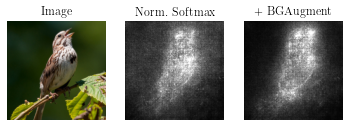

/Users/konstantinkobs/code/2022-dml-rrr/venv/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


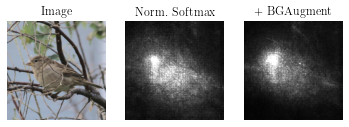

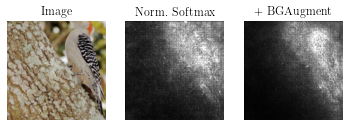

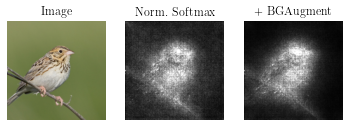

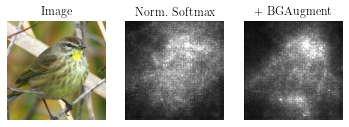

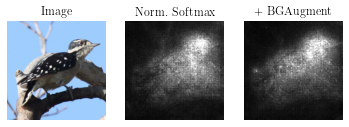

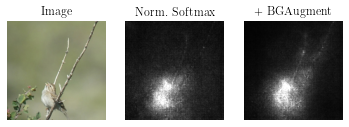

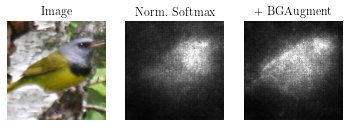

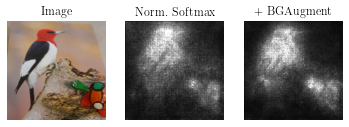

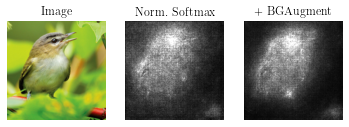

In [40]:
print("Creating base image embeddings")
# Base image: Creates a black image which is transformed/normalized
base_img, _ = val_transform(Image.new("RGB", (500, 500)), Image.new("L", (500, 500)))
base_embeddings = {
    name: model(base_img.unsqueeze(0).to(device)).detach() for name, model in models.items()
}

# hyperparams
num_samples = 25
std_dev_spread = 0.15
percentile = 0.99


for image_id in image_ids:
    item = dataset[image_id]
    image = item["inputs"].unsqueeze(0).to(device)
    mask = item["masks"].to(device)

    plt.subplot(1, len(models)+1, 1)
    plt.axis("off")
    plt.title("Image")
    plt.imshow(inv_transform(image.squeeze()).permute(1, 2, 0).cpu().numpy())

    for i, (name, model) in enumerate(models.items()):
        data = image.repeat(num_samples, 1, 1, 1)
        data += torch.randn_like(data) * std_dev_spread * (data.max() - data.min())
        _ = data.requires_grad_()

        out = model(data)
        loss = model.loss_func.base_loss_func.distance(out, base_embeddings[name]).mean()
        loss.backward()

        grads = data.grad.mean(dim=1).detach()

        # process grads
        grads = grads.abs().sum(dim=0).detach()

        v_max = torch.quantile(torch.flatten(grads), percentile)
        v_min = torch.min(grads)
        attention = torch.clamp((grads - v_min) / (v_max - v_min), 0.0, 1.0)

        plt.subplot(1, len(models)+1, i+2)
        plt.axis("off")
        plt.title(name)
        plt.imshow(attention.squeeze(0), cmap="gray")

    plt.savefig(f"./attention_results/attention_{image_id}.png", dpi=300, bbox_inches="tight")
    plt.show()